# Adaptive Boosting (AdaBoost)

Neste notebook, apresentamos o algoritmo Adaptive Boosting (AdaBoost). O objetivo é obter intuições sobre a máquina interna de AdaBoost e boosting em geral.

Vamos carregar o conjunto de dados "pinguim". Predizeremos as espécies de pinguins a partir das características de comprimento e profundidade do colmo.

In [2]:
import pandas as pd

penguins = pd.read_csv("penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

data, target = penguins[culmen_columns], penguins[target_column]
range_features = {
    feature_name: (data[feature_name].min() - 1, data[feature_name].max() + 1)
    for feature_name in data.columns}

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

Além disso, também estamos usando a função usada no caderno anterior para traçar a função de decisão da árvore.

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")

    return ax

Vamos treinar propositadamente uma árvore de decisão rasa. Por ser raso, é improvável que se ajuste demais e alguns dos exemplos de treinamento serão classificados incorretamente.

In [4]:
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

palette = ["tab:red", "tab:blue", "black"]

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target)

DecisionTreeClassifier(max_depth=2, random_state=0)

Podemos prever no mesmo conjunto de dados e verificar quais amostras foram classificadas incorretamente.

In [5]:
target_predicted = tree.predict(data)
misclassified_samples_idx = np.flatnonzero(target != target_predicted)
data_misclassified = data.iloc[misclassified_samples_idx]

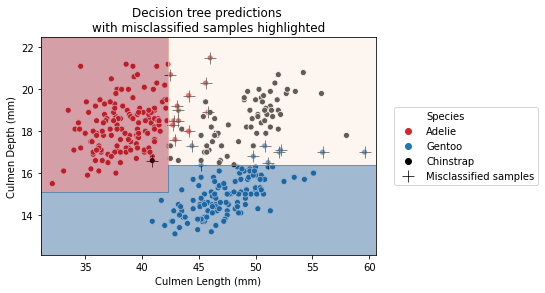

In [6]:
# plot the original dataset
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
# plot the misclassified samples
ax = sns.scatterplot(data=data_misclassified, x=culmen_columns[0],
                     y=culmen_columns[1], label="Misclassified samples",
                     marker="+", s=150, color="k")
plot_decision_function(tree, range_features, ax=ax)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Decision tree predictions \nwith misclassified samples "
              "highlighted")

Observamos que várias amostras foram classificadas incorretamente pelo classificador.

Mencionamos que o boosting depende da criação de um novo classificador que tenta corrigir esses erros de classificação. No scikit-learn, os alunos têm um parâmetro sample_weight que o força a prestar mais atenção às amostras com pesos mais altos durante o treinamento.

Este parâmetro é definido ao chamar classifier.fit (X, y, amostra_peso = pesos). Usaremos esse truque para criar um novo classificador 'descartando' todas as amostras classificadas corretamente e considerando apenas as amostras classificadas incorretamente. Assim, as amostras classificadas incorretamente receberão um peso de 1 e as amostras bem classificadas receberão um peso de 0.

In [7]:
sample_weight = np.zeros_like(target, dtype=int)
sample_weight[misclassified_samples_idx] = 1

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target, sample_weight=sample_weight)

DecisionTreeClassifier(max_depth=2, random_state=0)

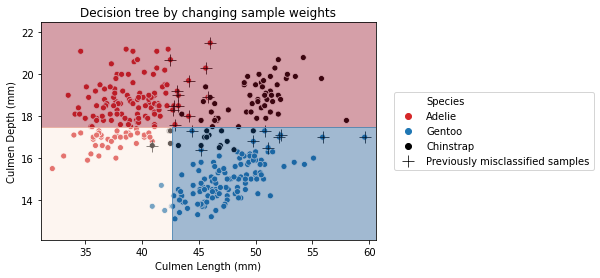

In [8]:
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
ax = sns.scatterplot(data=data_misclassified, x=culmen_columns[0],
                     y=culmen_columns[1],
                     label="Previously misclassified samples",
                     marker="+", s=150, color="k")
plot_decision_function(tree, range_features, ax=ax)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Decision tree by changing sample weights")

Vemos que a função de decisão mudou drasticamente. Qualitativamente, vemos que as amostras anteriormente classificadas incorretamente agora estão classificadas corretamente.

In [9]:
target_predicted = tree.predict(data)
newly_misclassified_samples_idx = np.flatnonzero(target != target_predicted)
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx)

print(f"Number of samples previously misclassified and"
      f"still misclassified: {len(remaining_misclassified_samples_idx)}")

Number of samples previously misclassified and still misclassified: 0


No entanto, estamos cometendo erros em amostras anteriormente bem classificadas. Assim, temos a intuição de que devemos pesar as previsões de cada classificador de maneira diferente, muito provavelmente usando o número de erros que cada classificador está cometendo.

Portanto, poderíamos usar o erro de classificação para combinar as duas árvores.

In [10]:
ensemble_weight = [
    (target.shape[0] - len(misclassified_samples_idx)) / target.shape[0],
    (target.shape[0] - len(newly_misclassified_samples_idx)) / target.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

O primeiro classificador teve 94% de precisão e o segundo 69% de precisão. Portanto, ao prever uma classe, devemos confiar no primeiro classificador um pouco mais do que no segundo. Poderíamos usar esses valores de precisão para ponderar as previsões de cada aluno.

Para resumir, o boosting aprende vários classificadores, cada um dos quais se concentrará mais ou menos em amostras específicas do conjunto de dados. Boosting é, portanto, diferente de bagging: aqui nunca reamostramos nosso conjunto de dados, apenas atribuímos pesos diferentes ao conjunto de dados original.

O impulso requer alguma estratégia para combinar os alunos:

* é preciso definir uma forma de calcular os pesos a serem atribuídos às amostras;
* é preciso atribuir um peso a cada aluno ao fazer previsões.

Na verdade, definimos um esquema realmente simples para atribuir pesos amostrais e pesos ao aluno. No entanto, existem teorias estatísticas (como em AdaBoost) sobre como esses pesos de amostra e de aluno podem ser calculados de forma otimizada.

Usaremos o classificador AdaBoost implementado no scikit-learn e veremos os classificadores de árvore de decisão treinados.

In [11]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(base_estimator=base_estimator,
                              n_estimators=3, algorithm="SAMME",
                              random_state=0)
adaboost.fit(data, target)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   n_estimators=3, random_state=0)

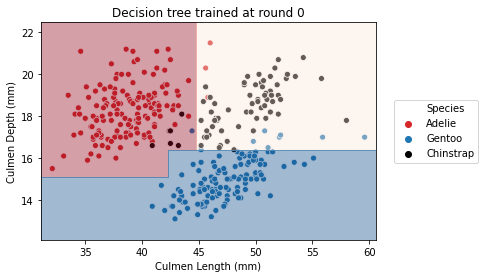

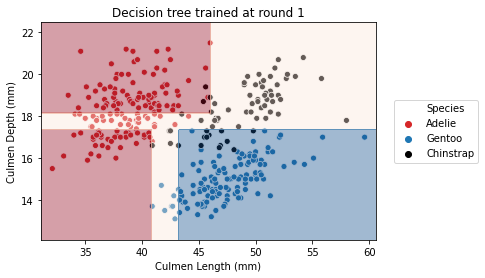

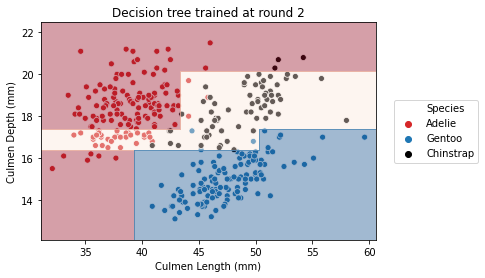

In [12]:
for boosting_round, tree in enumerate(adaboost.estimators_):
    plt.figure()
    ax = sns.scatterplot(x=culmen_columns[0], y=culmen_columns[1],
                         hue=target_column, data=penguins,
                         palette=palette)
    plot_decision_function(tree, range_features, ax=ax)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    _ = plt.title(f"Decision tree trained at round {boosting_round}")

In [13]:
print(f"Weight of each classifier: {adaboost.estimator_weights_}")

Weight of each classifier: [3.58351894 3.46901998 3.03303773]


In [14]:
print(f"Error of each classifier: {adaboost.estimator_errors_}")

Error of each classifier: [0.05263158 0.05864198 0.08787269]


Vemos que AdaBoost aprendeu três classificadores diferentes, cada um deles focando em amostras diferentes. Olhando os pesos de cada aluno, vemos que o conjunto dá o maior peso ao primeiro classificador. Isso realmente faz sentido quando olhamos para os erros de cada classificador. O primeiro classificador também tem o desempenho de generalização de classificação mais alto.

Embora o AdaBoost seja um bom algoritmo para demonstrar a maquinaria interna dos algoritmos de impulso, ele não é o mais eficiente. Este título é entregue ao algoritmo de árvore de decisão de aumento de gradiente (GBDT), que discutiremos após um breve exercício.

# 📝 Exercício M6.03

Este exercício visa verificar se o AdaBoost pode se ajustar demais. Faremos uma busca em grade e verificaremos as pontuações variando o número de estimadores.

Vamos primeiro carregar o conjunto de dados de habitação da Califórnia e dividi-lo em um conjunto de treinamento e teste.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

Em seguida, crie um `AbaBoostRegressor`. Use a função `sklearn.model_selection.validation_curve` para obter pontuações de treinamento e teste variando o número de estimadores. Use o erro médio absoluto como uma métrica passando `scoring = "neg_mean_absolute_error"`. Dica: varie o número de estimadores entre 1 e 60.

In [2]:
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import validation_curve

adaboost = AdaBoostRegressor()
param_range = np.unique(np.logspace(0, 1.8, num=30).astype(int))
train_scores, test_scores = validation_curve(
    adaboost, data_train, target_train,
    param_name="n_estimators", param_range=param_range,
    scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

Trace os erros médios de treinamento e teste. Você também pode representar graficamente o desvio padrão dos erros. Dica: você pode usar plt.errorbar.

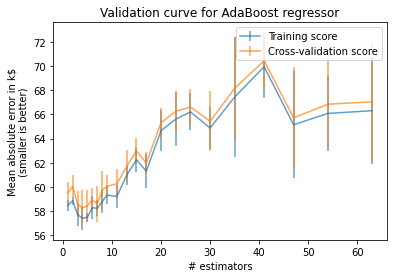

In [17]:
# solution
import matplotlib.pyplot as plt

plt.errorbar(param_range, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Training score",
             alpha=0.7)
plt.errorbar(param_range, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Cross-validation score",
             alpha=0.7)

plt.legend()
plt.ylabel("Mean absolute error in k$\n(smaller is better)")
plt.xlabel("# estimators")
_ = plt.title("Validation curve for AdaBoost regressor")

Traçando a curva de validação, podemos ver que o AdaBoost não está imune ao overfitting. Na verdade, existe um número ótimo de estimadores a ser encontrado. Adicionar muitos estimadores é prejudicial para o desempenho de generalização do modelo.

Repita o experimento usando uma floresta aleatória em vez de um regressor AdaBoost.

In [18]:
# solution
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
train_scores, test_scores = validation_curve(
    forest, data_train, target_train,
    param_name="n_estimators", param_range=param_range,
    scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

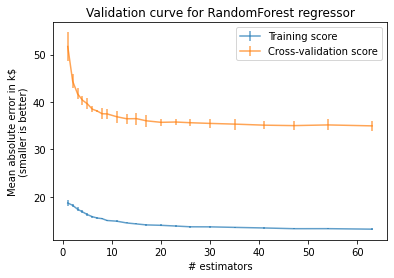

In [19]:
plt.errorbar(param_range, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Training score",
             alpha=0.7)
plt.errorbar(param_range, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Cross-validation score",
             alpha=0.7)

plt.legend()
plt.ylabel("Mean absolute error in k$\n(smaller is better)")
plt.xlabel("# estimators")
_ = plt.title("Validation curve for RandomForest regressor")

Em contraste com o regressor AdaBoost, podemos ver que aumentar o número de árvores na floresta aumentará o desempenho de generalização (diminuindo o erro absoluto médio) da floresta aleatória. Na verdade, uma floresta aleatória tem menos chance de sofrer de sobreajuste do que AdaBoost ao aumentar o número de estimadores.